# Pronóstico de precios de viviendas


**Introducción**: Es importante pronosticar el precios de las viviendas a partir de datos y no a partir de suposiciones o juicios de las personas.

**Contexto**: Se toman las viviendas de Bogotá (apartamentos y casas), sus características y precios de la página metrocuadrado.com

**Objetivo**: Estimar el precio de las casas y apartamentos de Bogotá y clasificarlos.

**Metodología**: 

1. Se toman las viviendas, se realiza un análisis descriptivo-exploratorio con el cual se observan oportunidades de transformación de los datos y entendimiento de los mismos.
2. Se realiza un modelo de regresión de los precios y un modelo de clasificación del tipo de vivienda y se evalúa su desempeño.
3. Se anotan las lecciones aprendidas.

![](https://d31dn7nfpuwjnm.cloudfront.net/images/valoraciones/0034/8136/casa-hipotecada-se-puede-vender.png?1565825047)

## 1. Importar e instalar librerías y cargar datos

In [1]:
! pip install sweetviz

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


En seguida se cargan los datos. Estos fueron obtenidos directamente de la página metrocuadrado.com por medio de webscraping (raspado web)

In [3]:
datos = pd.read_csv('https://drive.google.com/uc?id=1jwQo5QLpdgfjqi17NV3t_nt6t8uuERgJ')
datos

,Unnamed: 0,mtipoinmueble,mvalorventa,marea,mnrocuartos,mnrobanos,mnrogarajes,mzona,mbarrio,mnombrecomunbarrio
0,0,Apartamento,385000000,100.0,3,2,1.0,Chapinero,ALFONSO LOPEZ,GALERIAS
1,1,Apartamento,190810000,34.0,1,2,1.0,Norte,EL CODITO,EL REDIL
2,2,Apartamento,720000000,157.0,3,4,2.0,Noroccidente,NIZA SUBA,Cerros De Niza
3,3,Casa,1018660600,173.0,3,4,1.0,Otros,NaN,NaN
4,4,Apartamento,1850000000,190.0,3,4,2.0,Norte,CERROS DE LOS ALPES,CERROS DE LOS ALPES
...,...,...,...,...,...,...,...,...,...,...
9995,245,Apartamento,580000000,0.0,2,3,2.0,Norte,SANTA BARBARA OCCIDENTAL,Santa Barbara Occidental-Usaquén
9996,246,Casa,330000000,72.0,3,2,1.0,Norte,LA LIBERIA,LAS MARGARITAS
9997,247,Casa,1200000000,400.0,3,4,3.0,Norte,EL CONTADOR,El Contador
9998,248,Casa,642000000,191.0,4,4,2.0,Noroccidente,CIUDAD JARDIN NORTE,Gratamira


## 2. Análisis descriptivo básico

In [4]:
datos.describe()

,Unnamed: 0,mvalorventa,marea,mnrogarajes
count,10000.000000,1.000000e+04,10000.000000,9945.000000
mean,124.500000,2.666785e+09,170.825361,1.818602
std,72.171815,3.509427e+10,284.303566,1.113742
min,0.000000,1.100000e+06,0.000000,0.000000
25%,62.000000,4.090000e+08,68.000000,1.000000
50%,124.500000,6.900000e+08,117.000000,2.000000
75%,187.000000,1.250000e+09,200.000000,2.000000
max,249.000000,8.700000e+11,5808.000000,4.000000


In [5]:
datos.describe(include=np.object)

/tmp/ipykernel_440/2470324272.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  datos.describe(include=np.object)


,mtipoinmueble,mnrocuartos,mnrobanos,mzona,mbarrio,mnombrecomunbarrio
count,10000,9993,10000,9812,9945,9866
unique,2,6,7,8,363,790
top,Apartamento,3,2,Norte,SAN JOSE DE BAVARIA,SAN JOSE DE BAVARIA
freq,7736,5043,3276,5105,419,221


Se observa que `mnrocuartos` y `mnrobanos` se capturan como tipo textual, cuando deberían ser numéricas. Vamos a revisar de manera detallada lo que está sucediendo con estas variables


In [6]:
datos.mnrocuartos.unique()

array(['3', '1', '2', '4', '5', '5+', nan], dtype=object)

In [7]:
datos.mnrobanos.unique()

array(['2', '4', '1', '3', '5', '0', '5+'], dtype=object)

Hemos identificado el problema!
Vamos a corregirlo, más adelante

## 3. Preprocesamiento de datos

Con la función `apply`, cada vez que una fila contenga `5+` lo convierte en `6`.

In [8]:
# Las siguientes variables contienen valores 5+ indicando que hay mas de 5.
# En tal caso se pasan a 6 y se convierte a tipo float
datos2 = datos.copy()
datos2['mnrocuartos'] = datos.mnrocuartos.apply(lambda x: 6 if x=='5+' else x).astype(float)
datos2['mnrobanos'] = datos.mnrobanos.apply(lambda x: 6 if x=='5+' else x).astype(float)

Revisamos y efectivamente el problema fue corregido:

In [9]:
datos2.mnrocuartos.unique()

array([ 3.,  1.,  2.,  4.,  5.,  6., nan])

Ahora eliminemos la columna `Unnamed: 0`

In [10]:
datos2.drop(columns='Unnamed: 0', inplace=True)

## 4. Análisis descriptivo exploratorio (EDA)

Utilizando la librería `sweetviz` podemos realizar un EDA de manera eficiente.

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



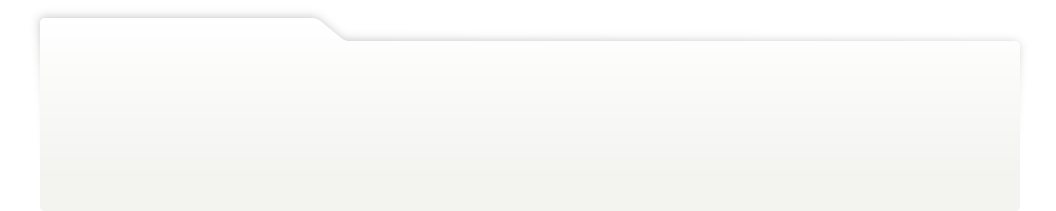
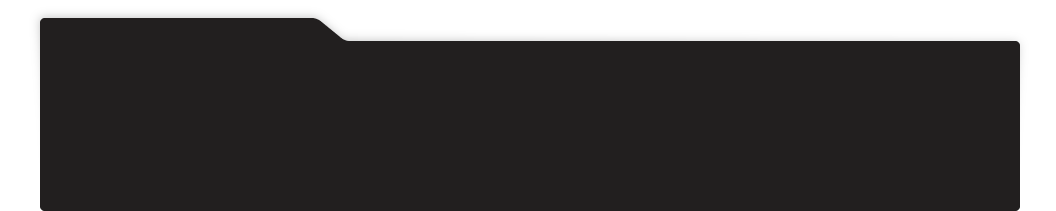
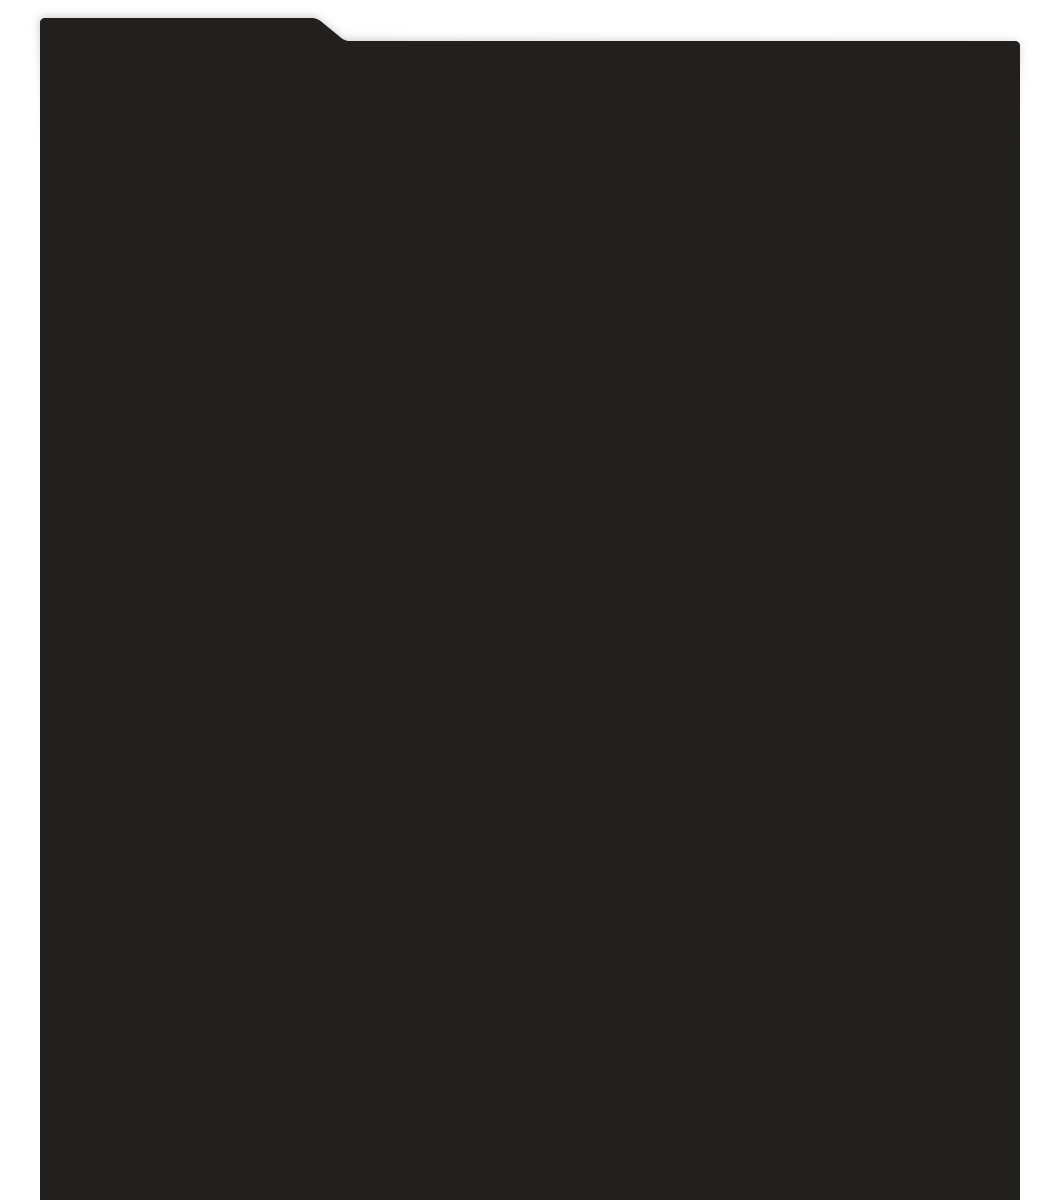
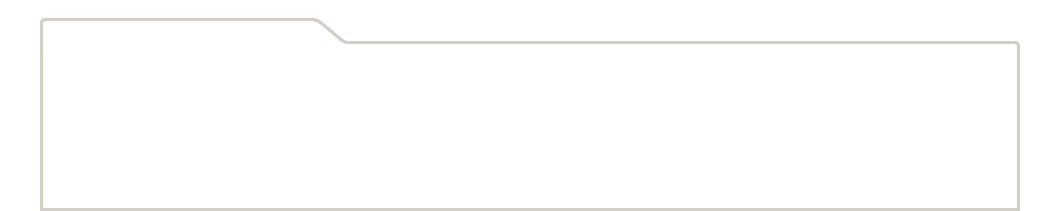
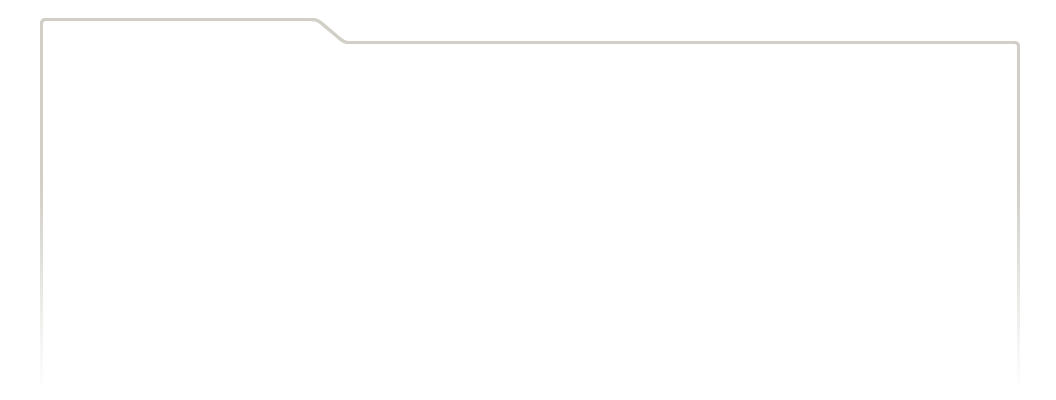
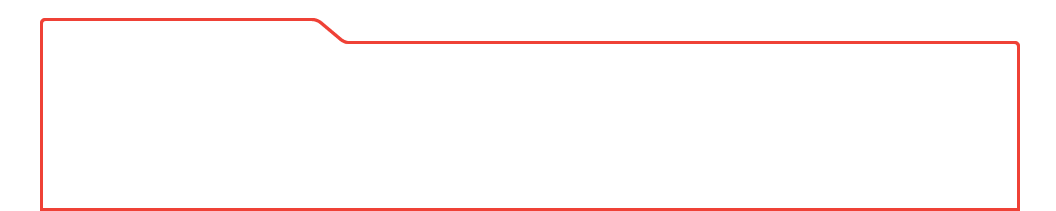
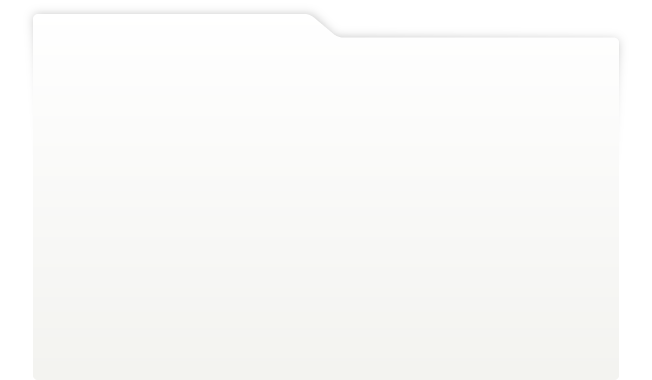
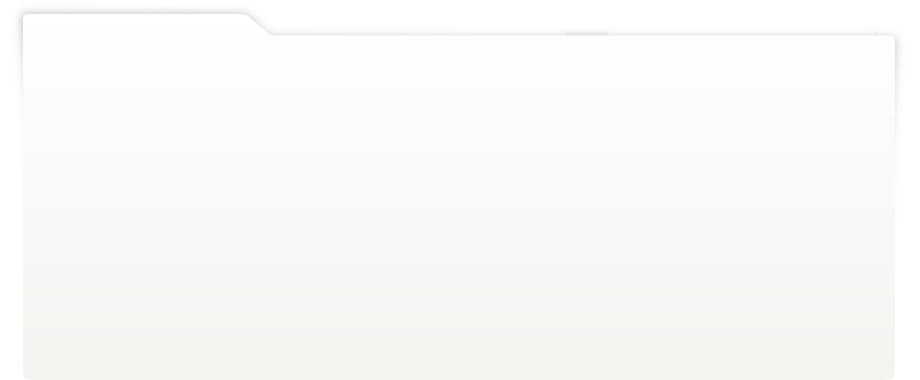
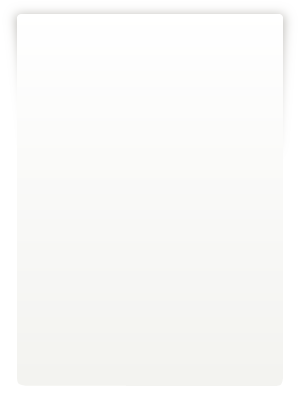
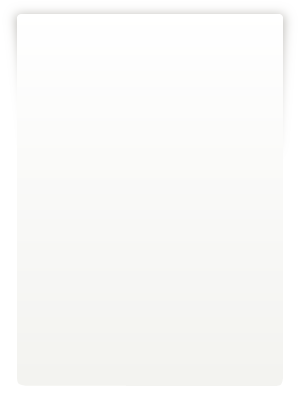
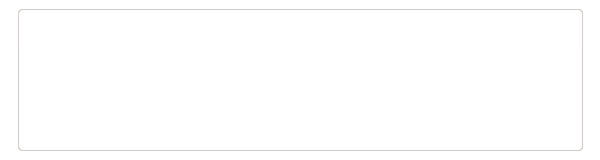
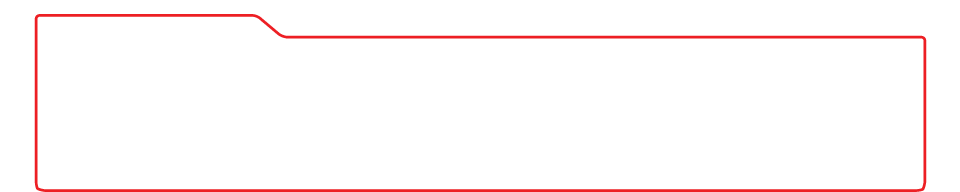
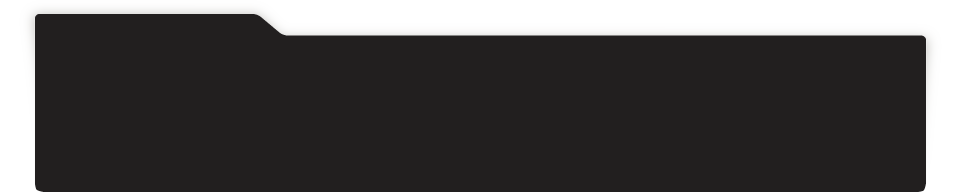
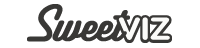
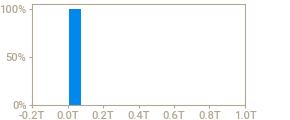
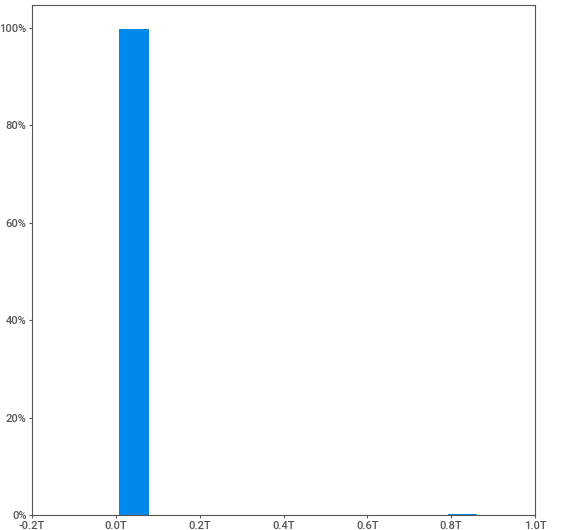
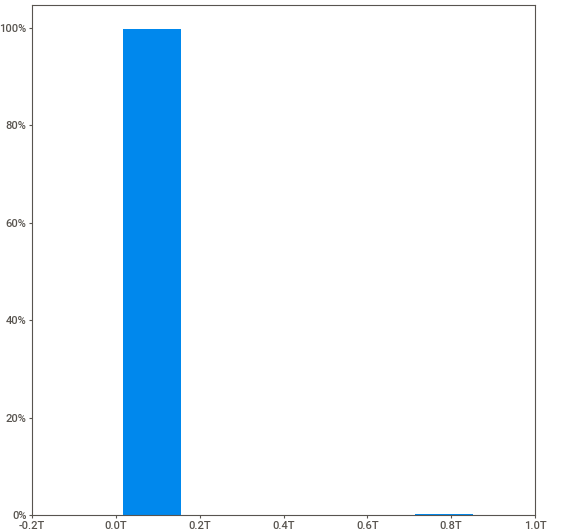
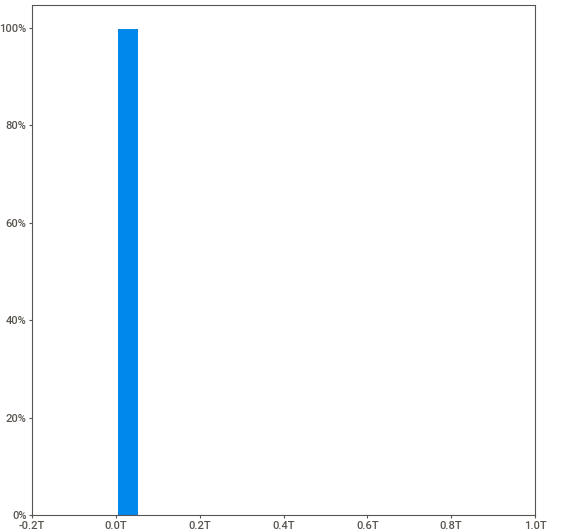
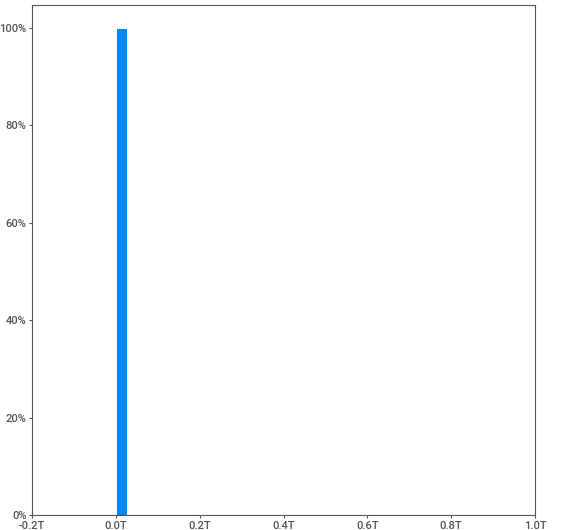
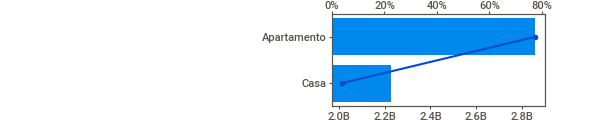
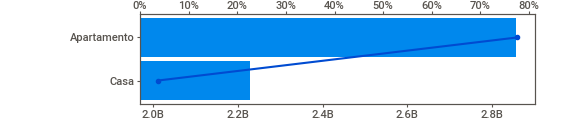
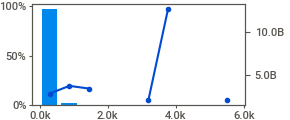
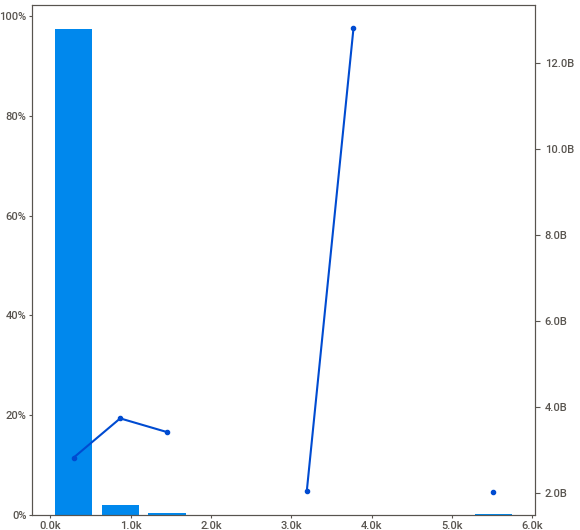
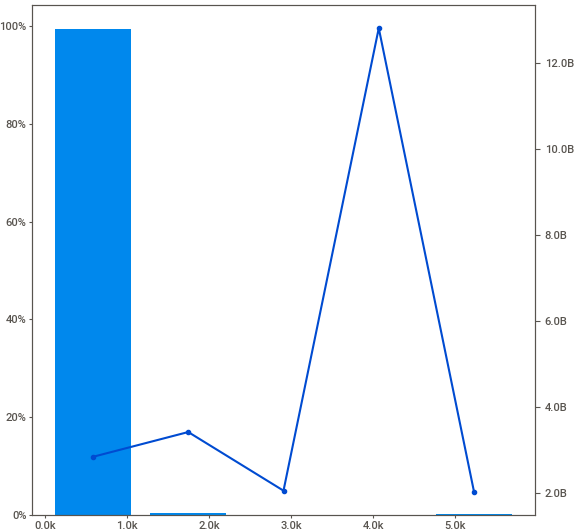
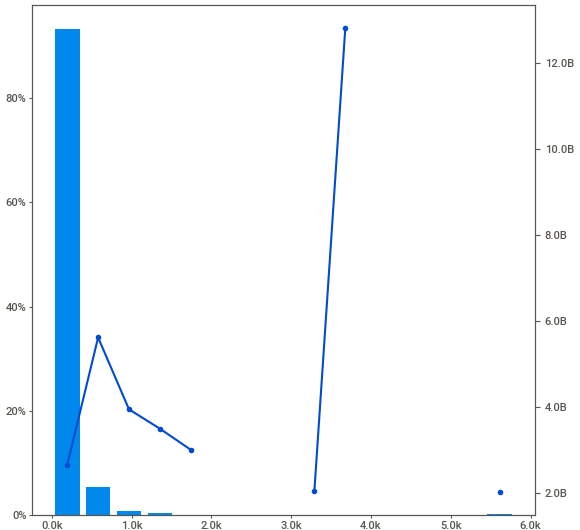
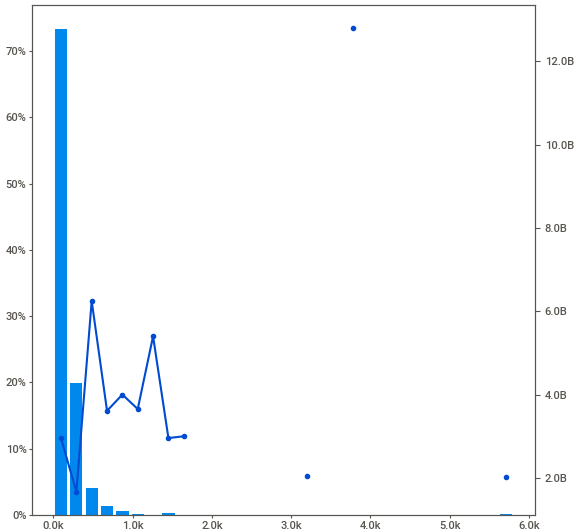
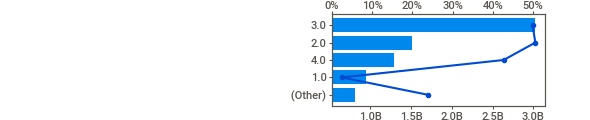
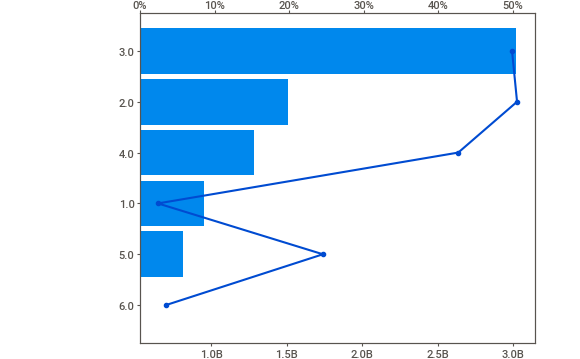
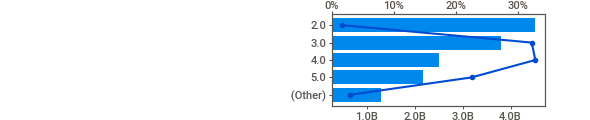
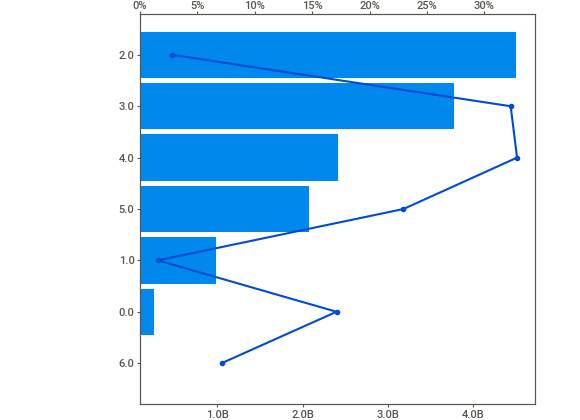
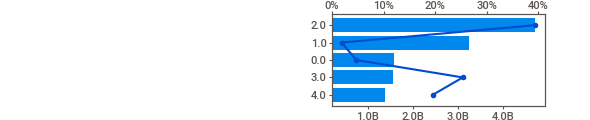
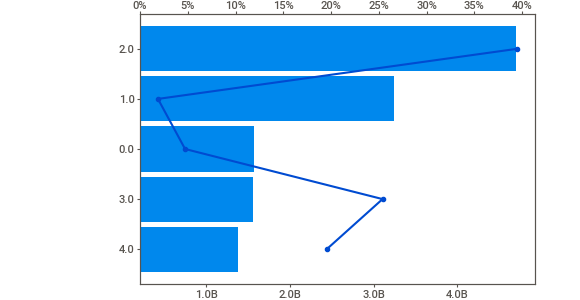
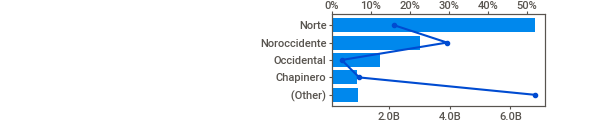
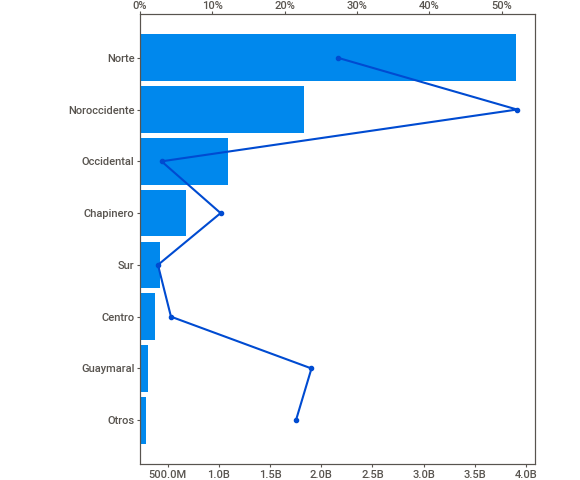
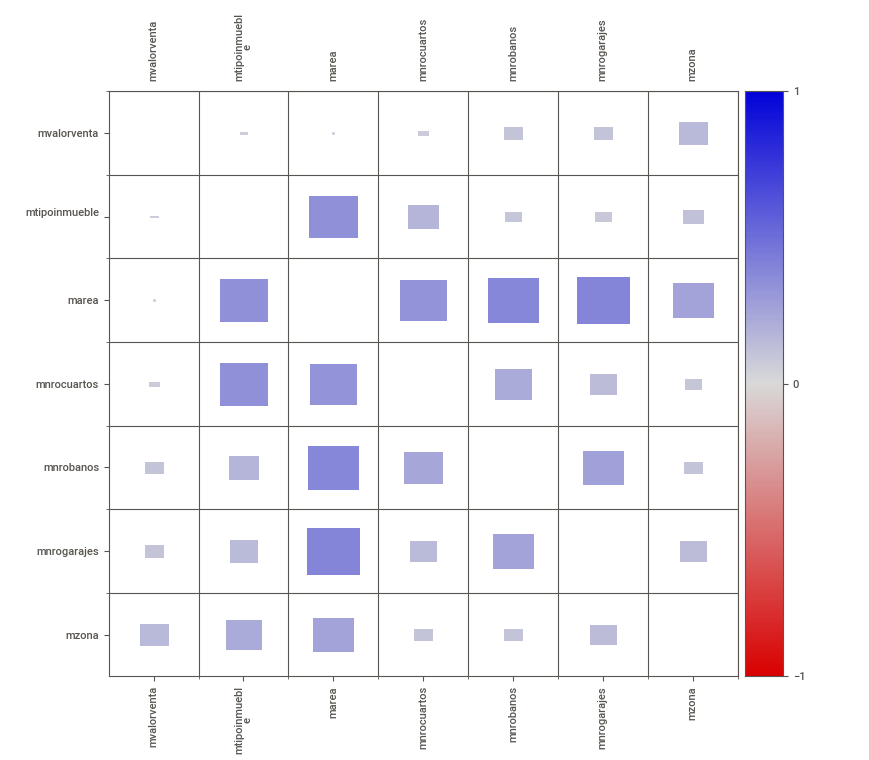
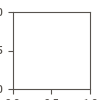

In [11]:
from IPython.display import HTML
reporte = sv.analyze(datos2, target_feat='mvalorventa')
reporte.show_html()
HTML('SWEETVIZ_REPORT.html')

**Análisis**

* Se identifican varias variables con fuerte sesgo a la derecha. Incluída la variable objetivo. En seguida se realiza un ajuste utilizando `log10`.

In [12]:
datos3 = datos2.copy()
datos3['mvalorventa_log10'] = datos2.mvalorventa.apply(np.log10)
datos3['marea_log10'] = datos2.marea.apply(lambda x: np.log10(x+1))

Revisemos si el valor de venta tiene valores `-inf`. Se ordenan de menor a mayor y se observa que están entre 1M y 1B.

In [13]:
datos3.mvalorventa_log10.sort_values()

974      6.041393
1814     6.041393
1394     6.041393
1604     6.041393
2024     6.041393
          ...    
4399    11.939519
3979    11.939519
4609    11.939519
4819    11.939519
4189    11.939519
Name: mvalorventa_log10, Length: 10000, dtype: float64

Ahora vamos a eliminar las viviendas repetidas

In [14]:
datos3 = datos3.drop_duplicates()

Se han eliminado aproximadamente el 80% de viviendas que estaban repetidas

Nuevamente ejecutamos el EDA con la tabla más limpia, el resultado es el siguiente:

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.




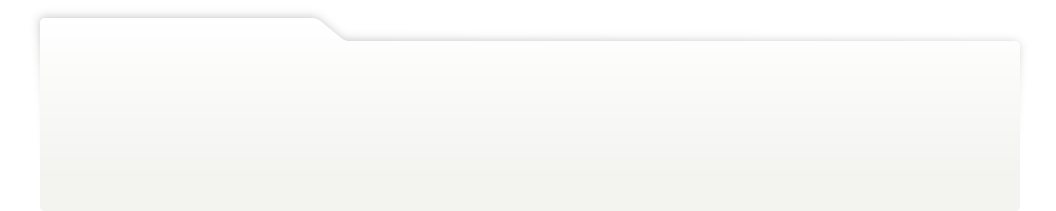
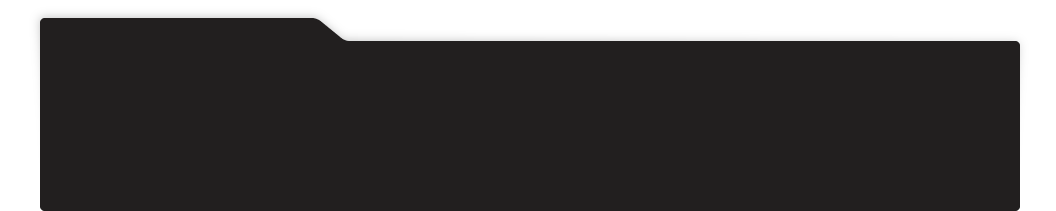
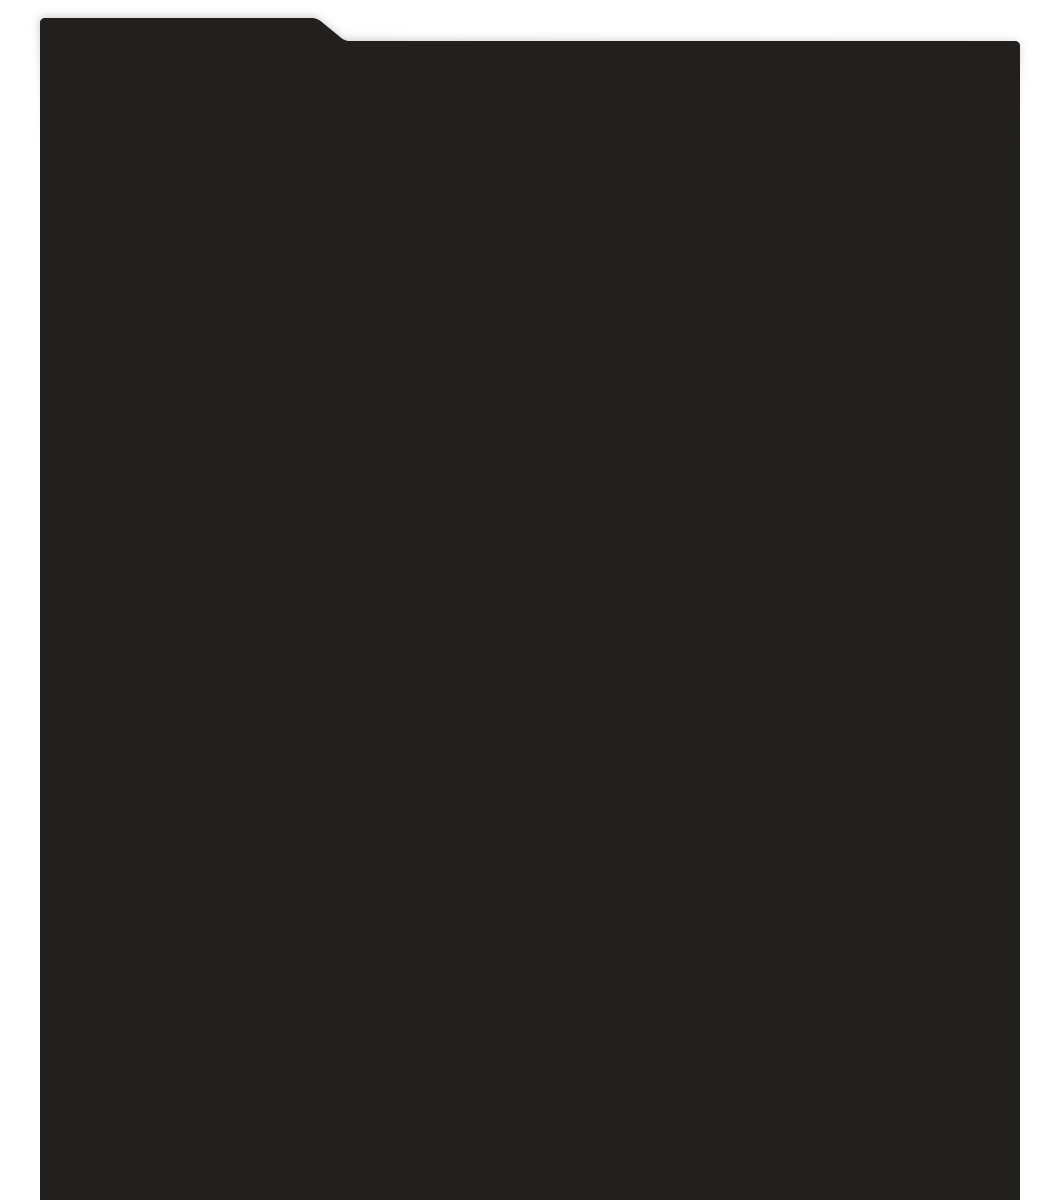
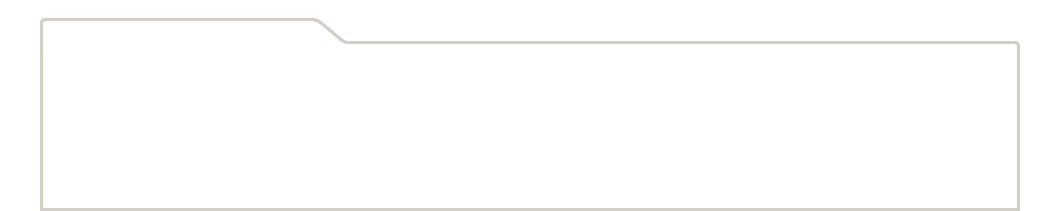
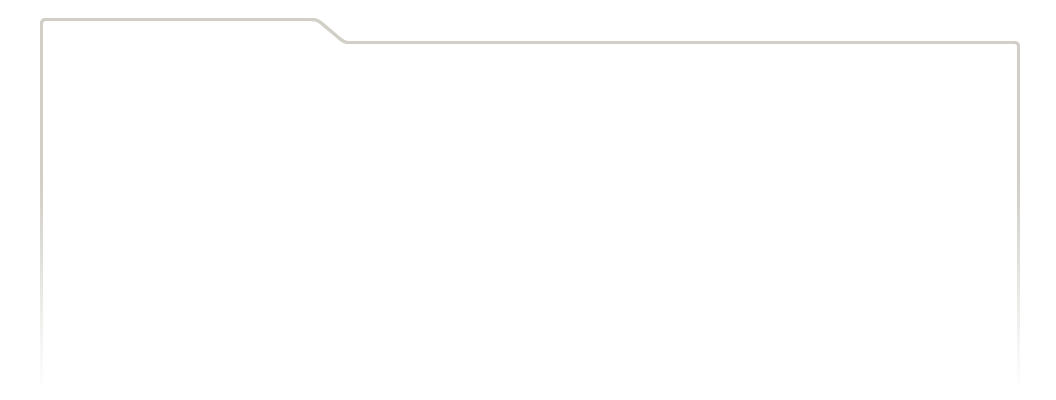
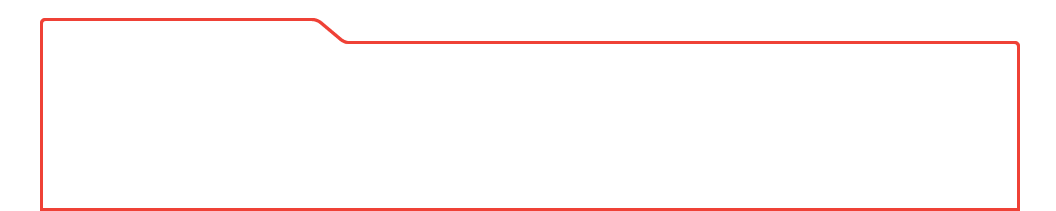
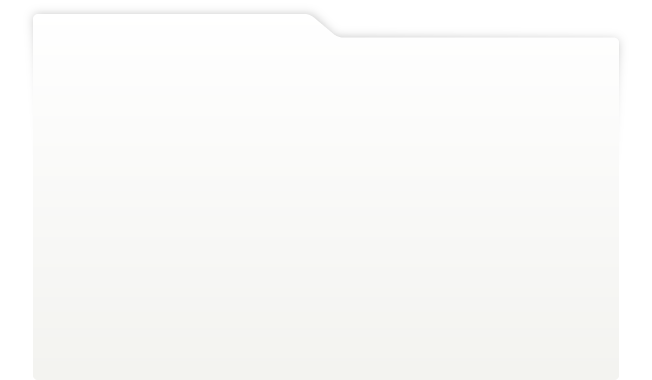
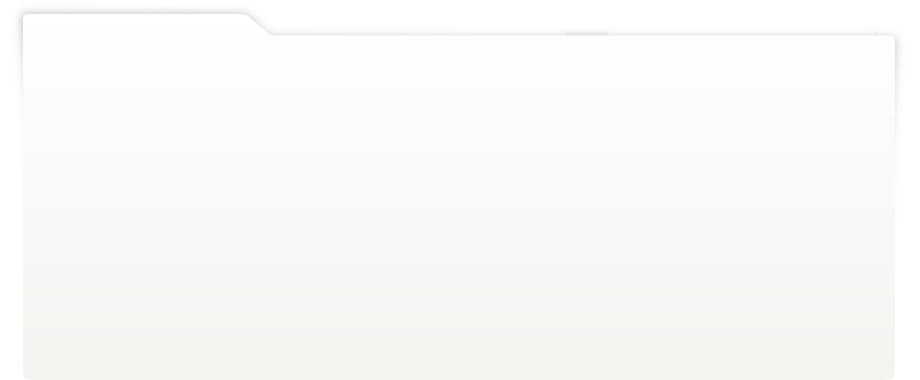
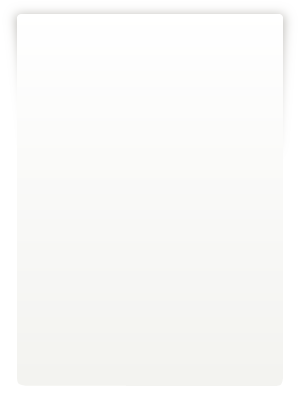
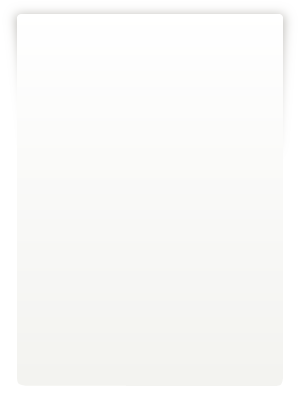
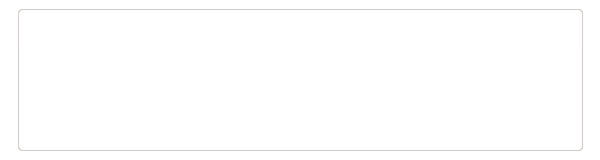
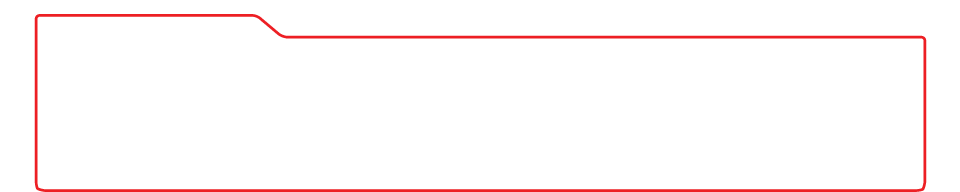
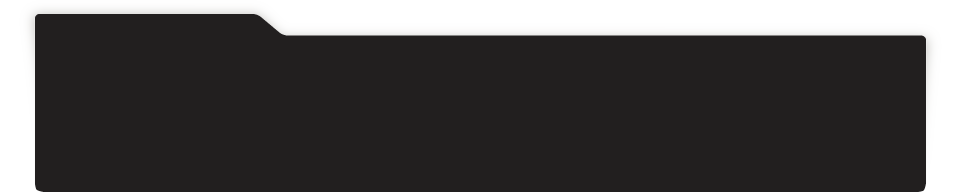
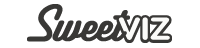
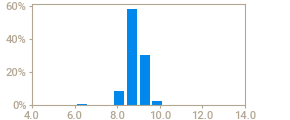
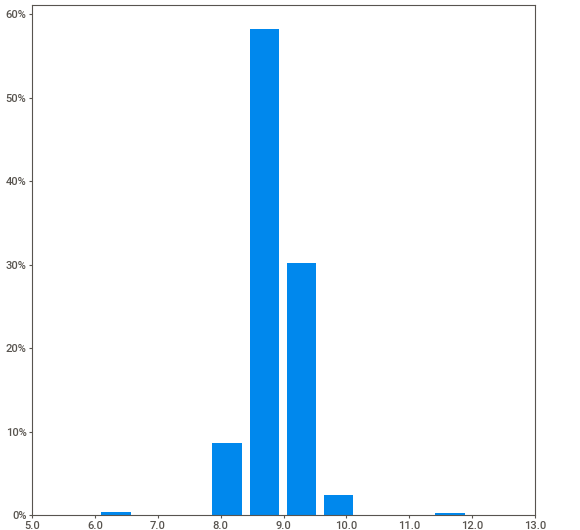
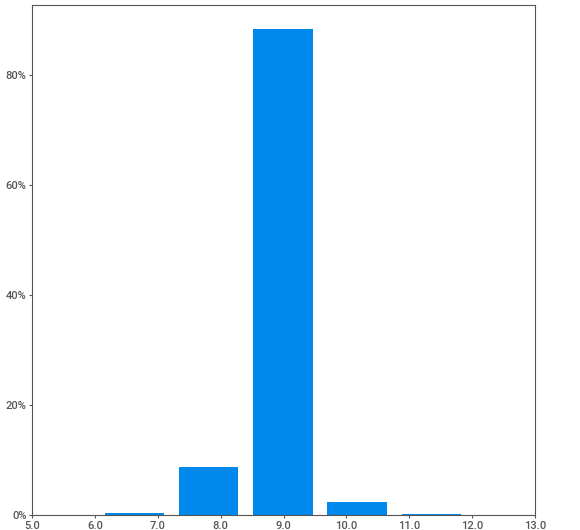
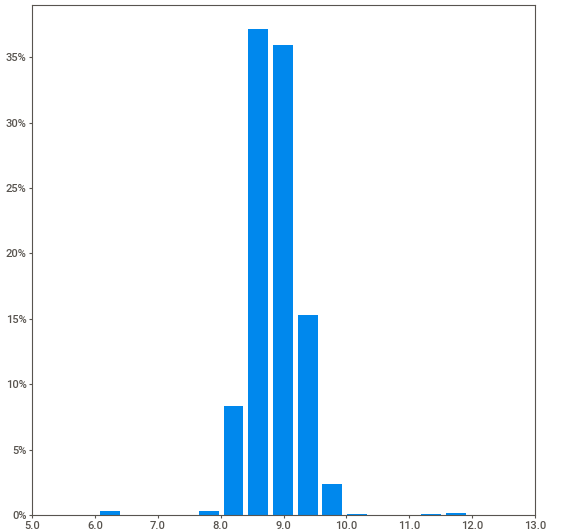
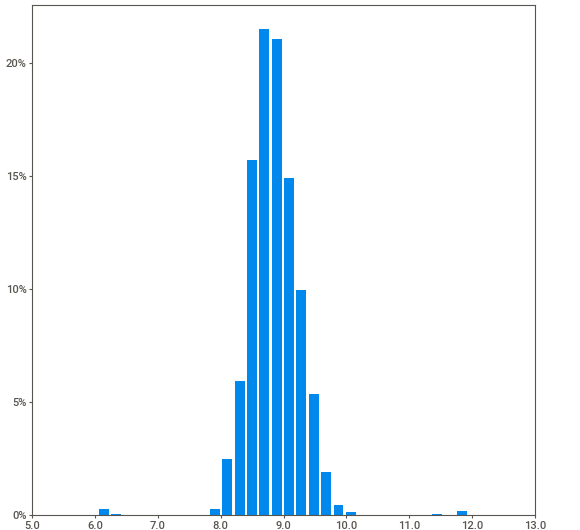
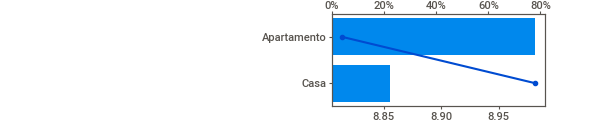
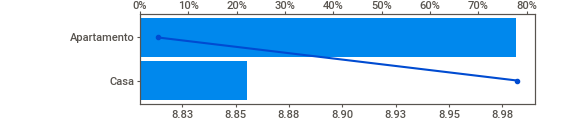
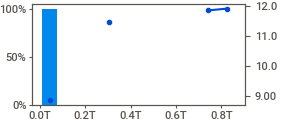
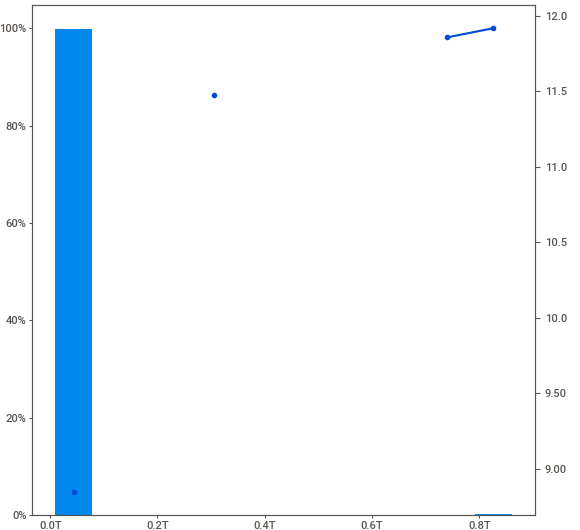
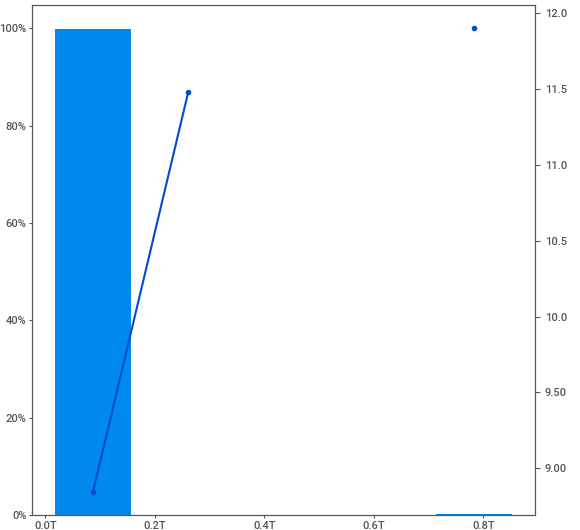
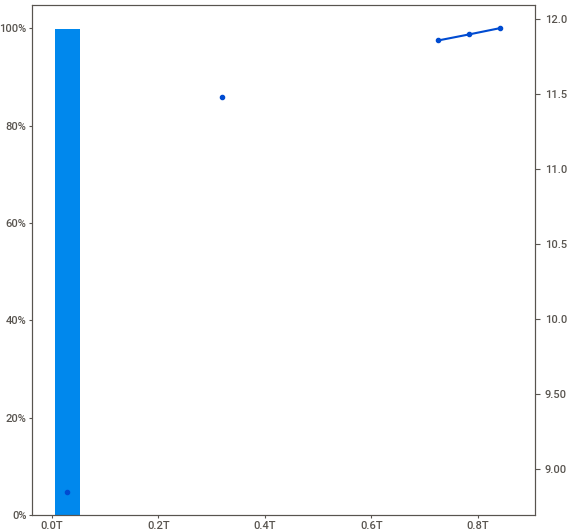
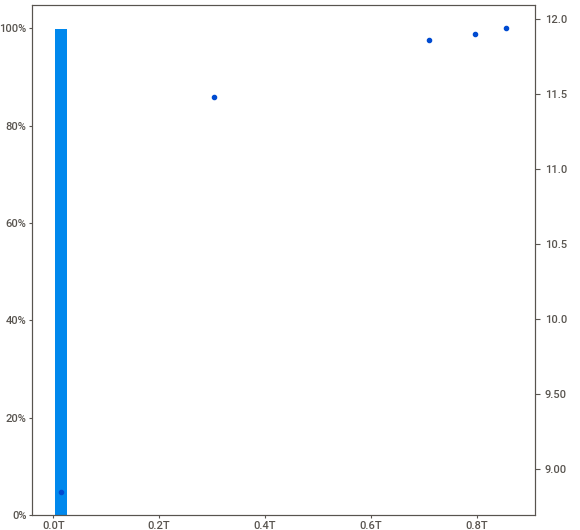
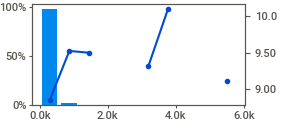
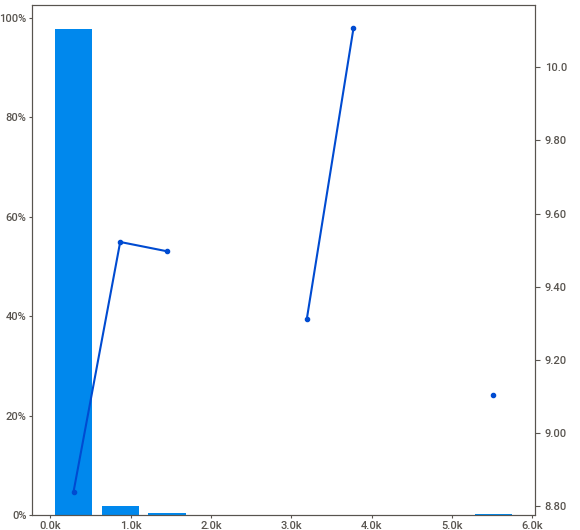
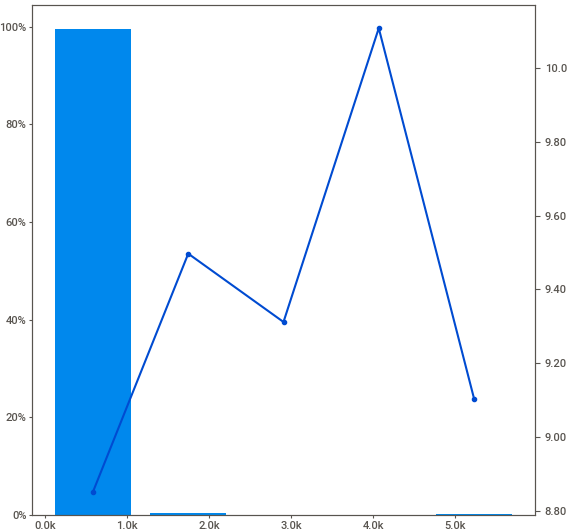
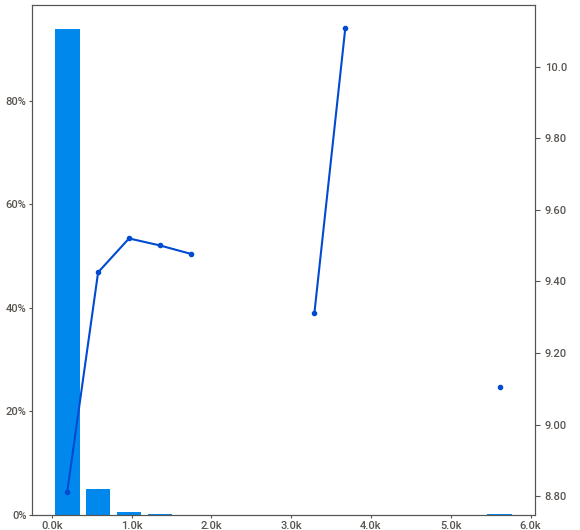
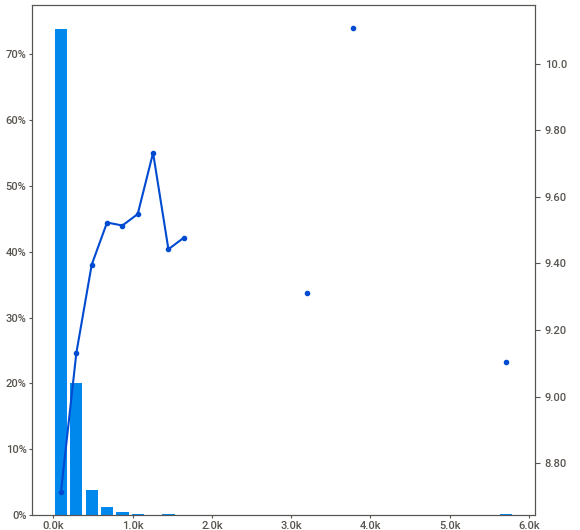
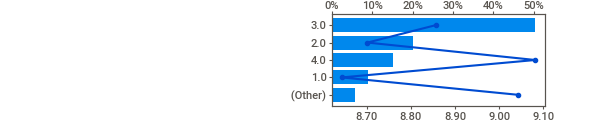
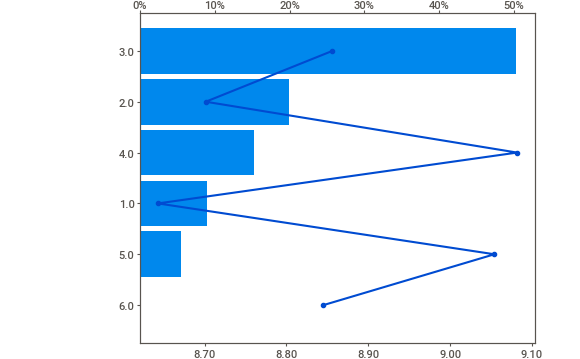
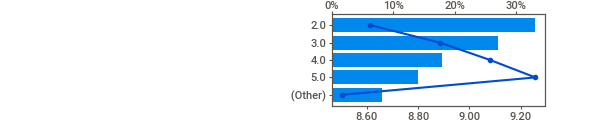
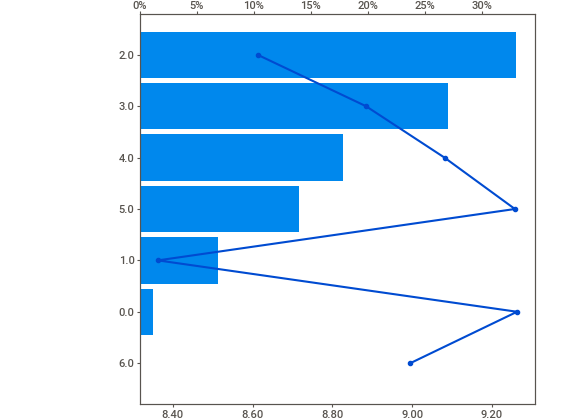
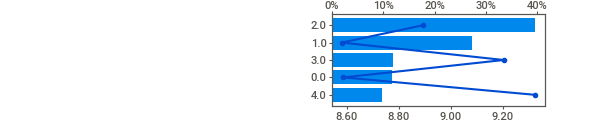
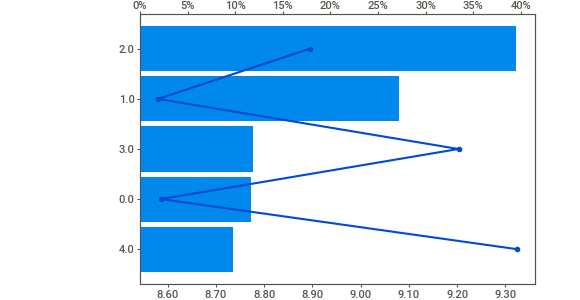
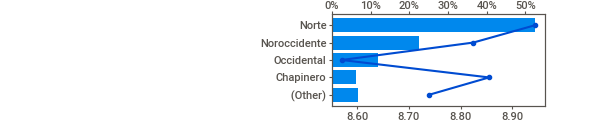
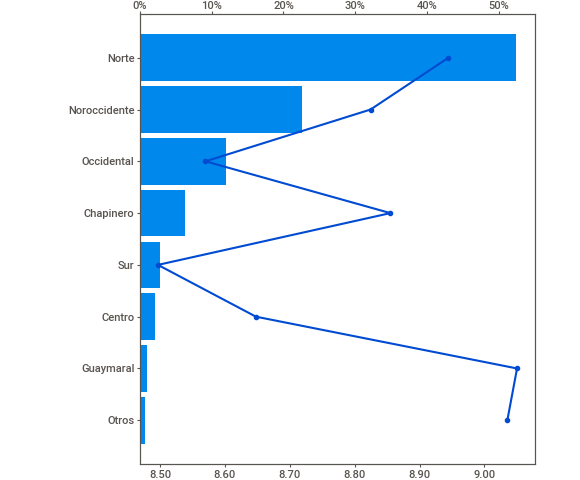
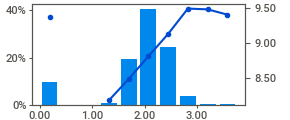
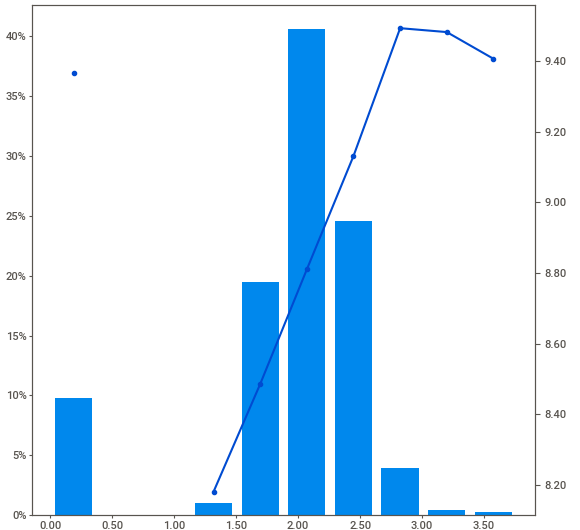
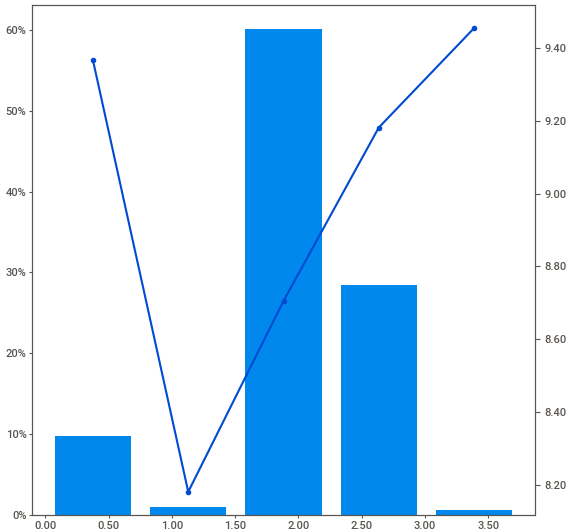
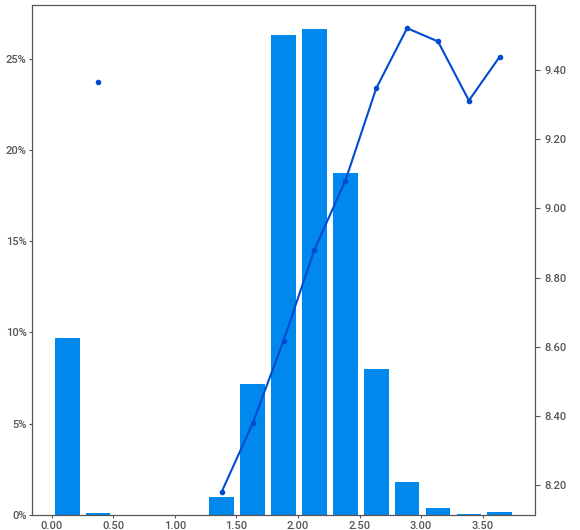
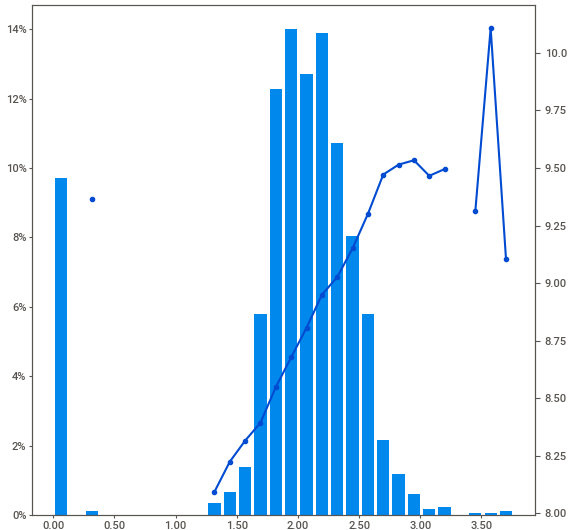
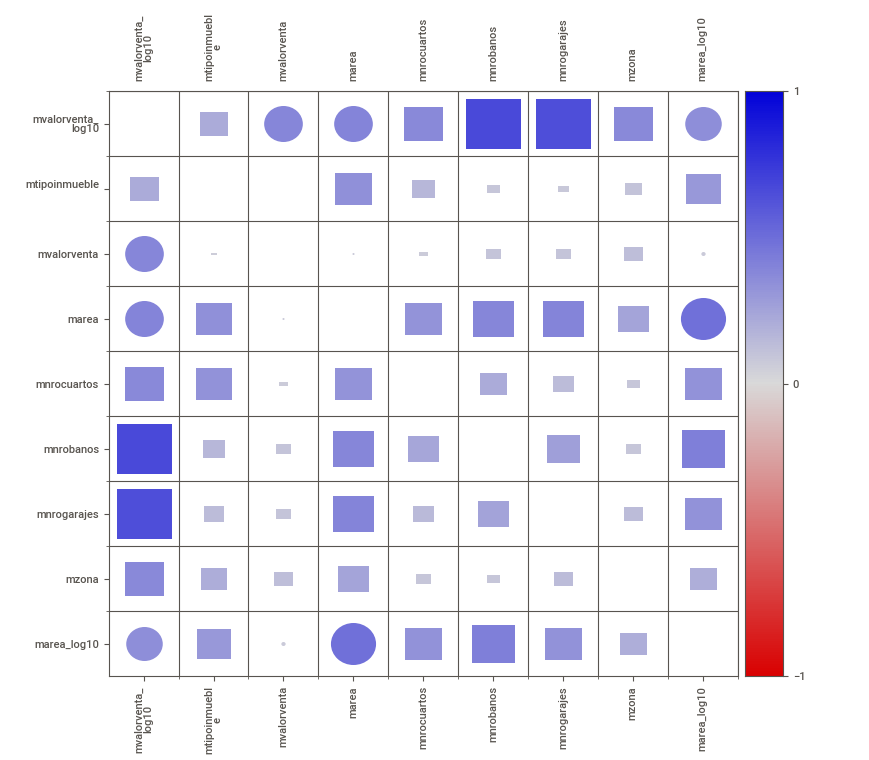
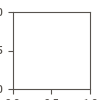

In [15]:
reporte = sv.analyze(datos3, target_feat='mvalorventa_log10')
reporte.show_html()
HTML('SWEETVIZ_REPORT.html')

Ahora vamos a confirmar la asociación entre `marea_log10` y `mvalorventa_log10`:

<AxesSubplot: xlabel='marea', ylabel='mvalorventa'>

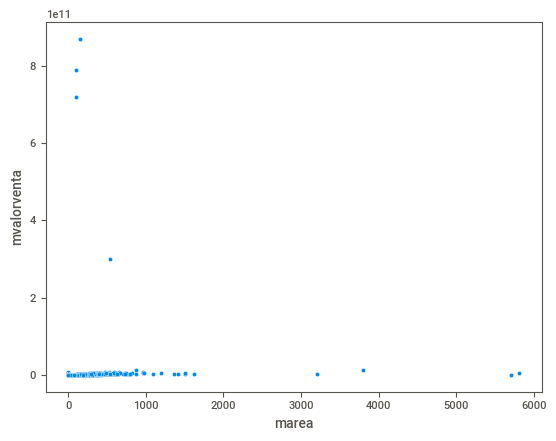

In [16]:
sns.scatterplot(x = 'marea', y = 'mvalorventa', data=datos3)

<AxesSubplot: xlabel='marea_log10', ylabel='mvalorventa_log10'>

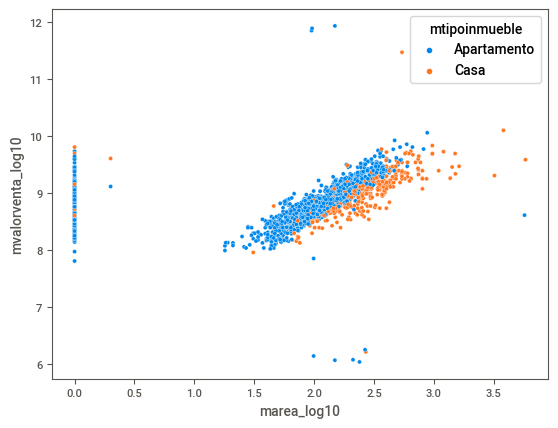

In [17]:
sns.scatterplot(x = 'marea_log10', y = 'mvalorventa_log10', hue='mtipoinmueble', data=datos3)

Se eliminarán los atípicos para realizar un modelo sobre las viviendas que tienen comportamiento más común.

**Advertencia**: Eliminar información no es la mejor opción. Siempre considere realizar imputación que tenga sentido o realizar modelos separados a los atípicos!

<AxesSubplot: xlabel='marea_log10', ylabel='mvalorventa_log10'>

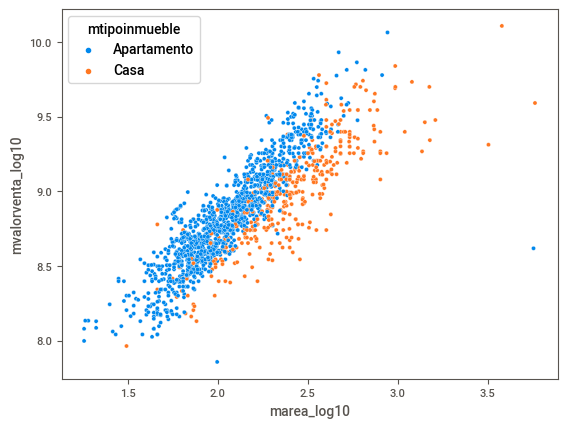

In [18]:
filtro = (datos3.marea_log10 > 1) & (datos3.mvalorventa_log10 < 11) & (datos3.mvalorventa_log10 > 7)
datos4 = datos3[filtro]
sns.scatterplot(x = 'marea_log10', y = 'mvalorventa_log10', hue='mtipoinmueble', data=datos4)

## 4. Modelo de pronóstico de precio

In [19]:
from sklearn.model_selection import train_test_split
# Paso 1: Preparación de datos
X = datos4[['marea_log10']]
y = datos4['mvalorventa_log10']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensiones de X_train: {X_train.shape}')
print(f'Dimensiones de X_test:  {X_test.shape}')
print(f'Dimensiones de y_train: {y_train.shape}')
print(f'Dimensiones de X_test:  {y_test.shape}')

Dimensiones de X_train: (1285, 1)
Dimensiones de X_test:  (322, 1)
Dimensiones de y_train: (1285,)
Dimensiones de X_test:  (322,)


In [20]:
from sklearn.linear_model import LinearRegression

# Paso 2: Definir modelo
modelo_lr = LinearRegression()

# Paso 3: Ajustar modelo
modelo_lr.fit(X_train, y_train)

# Paso 4: Pronosticos
y_pred = modelo_lr.predict(X_test)

<AxesSubplot: xlabel='mvalorventa_log10', ylabel='Count'>

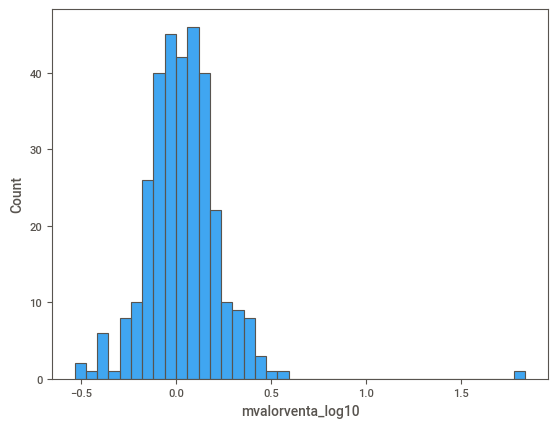

In [21]:
# Paso 5: Evaluar modelo

resid = y_pred - y_test
sns.histplot(resid)

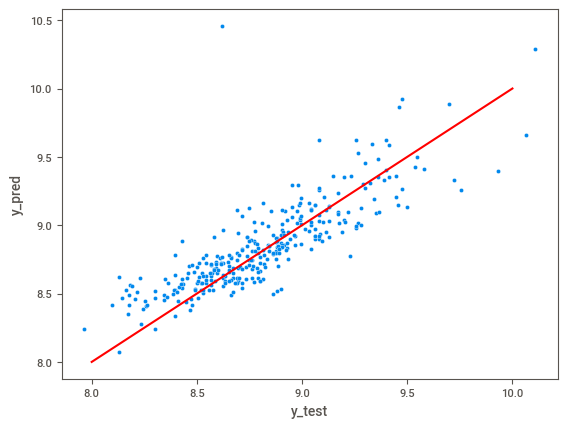

In [22]:
sns.scatterplot(x=y_test, y=y_pred)
plt.ylabel('y_pred')
plt.xlabel('y_test')
plt.plot([8,10], [8,10], 'r-')

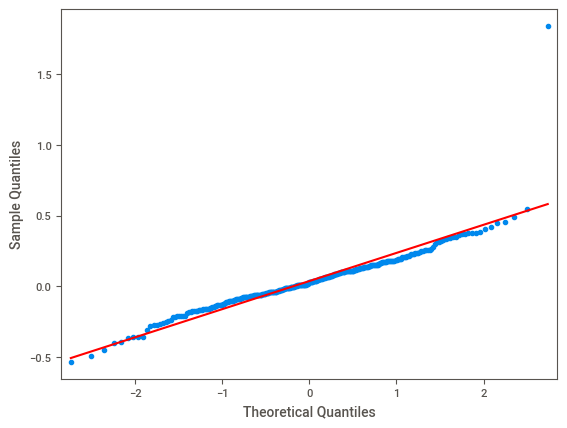

In [23]:
from statsmodels.graphics.gofplots import qqplot
qqplot(resid, line='s')
plt.show()

In [24]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print(f'RMSE: {mean_squared_error(10**y_test, 10**y_pred, squared=False)}')
print(f'MAE:  {mean_absolute_error(10**y_test, 10**y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(10**y_test, 10**y_pred)*100}')

RMSE: 1822733988.7287242
MAE:  457734733.61560184
MAPE: 56.37092239267956


Hemos identificado una vivienda con un error muy alto, ¿cuál será?

In [25]:
resid.sort_values(ascending=False)

2245    1.839748
1239    0.544039
3721    0.491360
8710    0.453148
4485    0.445876
          ...   
155    -0.395288
2722   -0.401193
123    -0.451940
78     -0.493734
726    -0.534097
Name: mvalorventa_log10, Length: 322, dtype: float64

La vivienda que causa el problema es la **2245**

In [26]:
datos4.loc[2245]

mtipoinmueble            Apartamento
mvalorventa                415000000
marea                         5700.0
mnrocuartos                      2.0
mnrobanos                        2.0
mnrogarajes                      0.0
mzona                          Norte
mbarrio               MOCHUELO NORTE
mnombrecomunbarrio           Usaquen
mvalorventa_log10           8.618048
marea_log10                 3.755951
Name: 2245, dtype: object

Hemos encontrado el problema! El precio estimado tan alto se debe a un error de digitación del área. Como el área es muy alta, la estimación del precio también lo será. Vamos a intentar imputar este valor, revisando los precios de venta en `Mochuelo Norte`

In [27]:
filtro = (datos4.mbarrio == 'MOCHUELO NORTE')
datos4[filtro]

,mtipoinmueble,mvalorventa,marea,mnrocuartos,mnrobanos,mnrogarajes,mzona,mbarrio,mnombrecomunbarrio,mvalorventa_log10,marea_log10
2245,Apartamento,415000000,5700.0,2.0,2.0,0.0,Norte,MOCHUELO NORTE,Usaquen,8.618048,3.755951
2974,Apartamento,720000000,146.0,3.0,2.0,2.0,Norte,MOCHUELO NORTE,SANTA BARBARA,8.857332,2.167317
3228,Apartamento,1500000000,356.0,4.0,5.0,3.0,Norte,MOCHUELO NORTE,SANTA BARBARA,9.176091,2.552668
9974,Apartamento,595000000,114.0,3.0,3.0,1.0,Norte,MOCHUELO NORTE,Santa Bárbara,8.774517,2.060698


In [28]:
filtro = (datos4.mnombrecomunbarrio == 'Usaquen')
datos4[filtro]

,mtipoinmueble,mvalorventa,marea,mnrocuartos,mnrobanos,mnrogarajes,mzona,mbarrio,mnombrecomunbarrio,mvalorventa_log10,marea_log10
2245,Apartamento,415000000,5700.00,2.0,2.0,0.0,Norte,MOCHUELO NORTE,Usaquen,8.618048,3.755951
4984,Apartamento,660000000,100.88,3.0,3.0,2.0,Norte,SAN GABRIEL NORTE,Usaquen,8.819544,2.008089
4985,Apartamento,710000000,107.73,3.0,3.0,2.0,Norte,SAN GABRIEL NORTE,Usaquen,8.851258,2.036349
6987,Apartamento,3200000000,333.00,3.0,5.0,0.0,Norte,USAQUEN,Usaquen,9.505150,2.523746


Probablemente el error de digitación es causa del punto decimal que está mal puesto. Entonces vamos a corregir el área de esa vivienda pasando de $5700m^2$ a $57.00m^2$.

In [29]:
datos5 = datos4.copy()
datos5['marea'][2245] = 57
datos5['marea_log10'][2245] = np.log10(57)
datos5.loc[2245]

/tmp/ipykernel_440/616901120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos5['marea'][2245] = 57
/tmp/ipykernel_440/616901120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos5['marea_log10'][2245] = np.log10(57)


mtipoinmueble            Apartamento
mvalorventa                415000000
marea                           57.0
mnrocuartos                      2.0
mnrobanos                        2.0
mnrogarajes                      0.0
mzona                          Norte
mbarrio               MOCHUELO NORTE
mnombrecomunbarrio           Usaquen
mvalorventa_log10           8.618048
marea_log10                 1.755875
Name: 2245, dtype: object

Hemos realizado el ajuste, vamos a volver a generar el modelo y revisar sus métricas

Dimensiones de X_train: (1285, 1)
Dimensiones de X_test:  (322, 1)
Dimensiones de y_train: (1285,)
Dimensiones de X_test:  (322,)


<AxesSubplot: xlabel='mvalorventa_log10', ylabel='Count'>

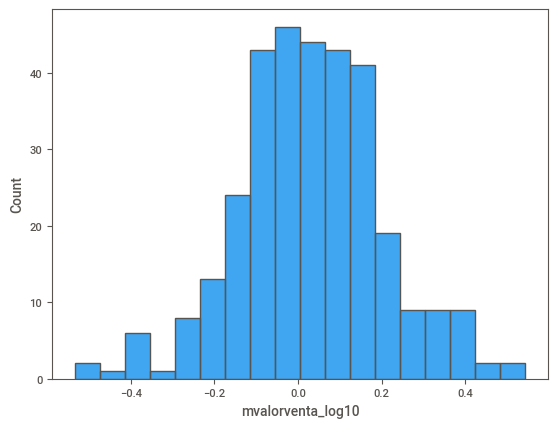

In [30]:
# Paso 1: Preparación de datos
X = datos5[['marea_log10']]
y = datos5['mvalorventa_log10']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensiones de X_train: {X_train.shape}')
print(f'Dimensiones de X_test:  {X_test.shape}')
print(f'Dimensiones de y_train: {y_train.shape}')
print(f'Dimensiones de X_test:  {y_test.shape}')

# Paso 2: Definir modelo
modelo_lr = LinearRegression()

# Paso 3: Ajustar modelo
modelo_lr.fit(X_train, y_train)

# Paso 4: Pronosticos
y_pred = modelo_lr.predict(X_test)

# Paso 5: Evaluar modelo

resid = y_pred - y_test
sns.histplot(resid)

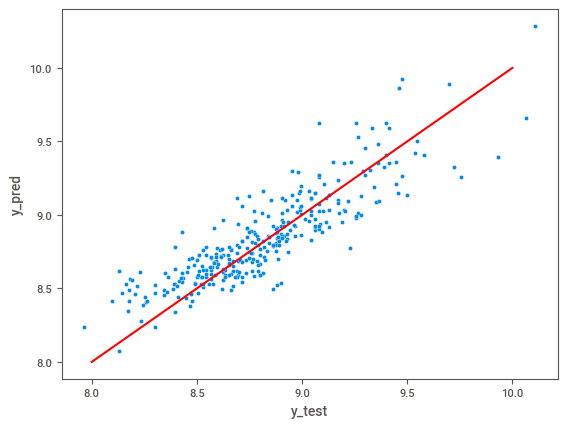

In [31]:
sns.scatterplot(x=y_test, y=y_pred)
plt.ylabel('y_pred')
plt.xlabel('y_test')
plt.plot([8,10], [8,10], 'r-')

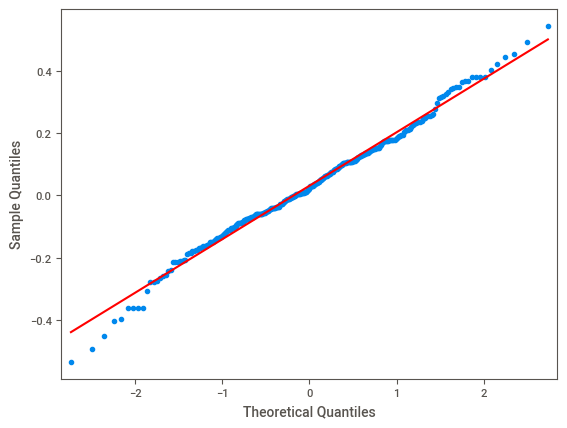

In [32]:
from statsmodels.graphics.gofplots import qqplot
qqplot(resid, line='s')
plt.show()

In [33]:
print(f'RMSE: {mean_squared_error(10**y_test, 10**y_pred, squared=False)}')
print(f'MAE:  {mean_absolute_error(10**y_test, 10**y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(10**y_test, 10**y_pred)*100}')

RMSE: 915854370.0202533
MAE:  370218990.28897756
MAPE: 35.2827914706014


En el caso de estudio, no se debería utilizar el RMSE o MAE como métrica para evaluar el error del modelo en pesos. En su lugar se debería utilizar el MAPE, la fórmula es la siguiete:

$$MAPE = \frac{1}{m} \sum_{j=1}^m \left| \frac{\hat y^{(j)} - y^{(j)}}{y^{(j)}}\right|$$

Por ejemplo, suponga que el error de una vivienda es 500M, el costo real de la vivienda es 500kM. Veamos cual sería en MAPE de esta vivienda:

$$MAPE = \frac{500M}{500000M}= 0.001 = 0.1\%$$

Volviendo al caso de estudio, mi modelo se está equivocando en un 35\% del valor real.

**Pycaret**

[Pycaret](https://pycaret.gitbook.io/docs/) es una librería Machine Learning de bajo código, que tiene la gran ventaja de generar y evaluar distintos modelos de manera muy rápida! Su desventaja es que el trabajo se torna muy rígido.

In [34]:
!pip install pycaret
# !pip uninstall scikit-learn -y
# !pip install scikit-learn==0.23.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 KB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2

In [35]:
from pycaret import regression

In [36]:
# Paso 1: Preparar datos para pycaret
X = datos5[['marea_log10', 'mtipoinmueble', 'mnrocuartos', 'mnrobanos', 'mnrogarajes', 'mzona']]
y = datos5[['mvalorventa_log10']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
datos5_train = pd.concat([X_train, y_train], axis=1)
regression.setup(datos5_train, target = 'mvalorventa_log10',
                 numeric_features=['mnrobanos', 'mnrogarajes', 'mnrocuartos'])

In [44]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/deepnote-config/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: problems found:
        - require?  X jupyter-js-widgets/extension
Paths used for configuration of notebook: 
    	/deepnote-config/jupyter/nbconfig/notebook.json


In [45]:
from ipywidgets import FloatProgress

In [46]:
best_model = regression.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:29:06
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [0]:
regression.evaluate_model(best_model)

In [0]:
regression.plot_model(best_model, plot='residuals_interactive')

## 5. Modelo de clasificación de tipo de vivienda

Vamos a pronosticar el tipo de vivienda (apartamento o casa) a partir de la información disponible.

In [0]:
sns.scatterplot(data=datos5, x = 'mvalorventa_log10', y = 'marea_log10', hue = 'mtipoinmueble')

In [0]:
sns.scatterplot(data=datos5, x = 'marea_log10', y = 'mtipoinmueble', hue = 'mtipoinmueble')

El objetivo es separar los puntos azules de los verdes!
Para esto vamos a utilizar un modelo de regresión logístico.

In [0]:
from sklearn.linear_model import LogisticRegression

# Paso 1: Preparar los datos
X = datos5[['mvalorventa_log10', 'marea_log10']]
y = datos5[['mtipoinmueble']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 2: Crear modelo
modelo_lr = LogisticRegression()

# Paso 3: Ajustar modelo
modelo_lr.fit(X_train, y_train)

# Paso 4: Pronosticos
y_pred = modelo_lr.predict(X_test)

In [0]:
# Paso 5: Evaluar modelo

# Gráficamente

# Paso 3: Evaluación del modelo
plt.figure(figsize=(10, 7))
sns.scatterplot(data=datos5, x='mvalorventa_log10', y='marea_log10', hue = 'mtipoinmueble', alpha=0.5)

# Creamos una grilla de valores que barran todos los valores posibles para area y precio
x0, x1 = np.meshgrid(
        np.linspace(8, 10, 100).reshape(-1, 1),
        np.linspace(1.5, 3, 100).reshape(-1, 1)
    )

# Construimos los valores de entrada X_new y su correspondiente salida
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = modelo_lr.predict_proba(X_new)

zz = y_proba[:, 1].reshape(x0.shape)

# Graficamos algunos valores de contorno (curvas de nivel) de la función sigmoide
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

# Se seleccionan dos puntos para graficar la línea límite de decisión
left_right = np.array([8, 10])
boundary = -(modelo_lr.coef_[0][0] * left_right + modelo_lr.intercept_[0]) / modelo_lr.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3, 8.5, "Casa ($\hat y = 1$)", fontsize=15, color="orange", ha="center")
#plt.text(1.8, 9.6, "Apartamento ($\hat y = 0$)", fontsize=15, color="b", ha="center")
plt.show()


**Así se verían los puntos y la sigmoide en 3D**

![](http://talimi.se/wp-content/uploads/2017/11/logistic-regression-in-3d-with-2-independent-variables.png)

In [0]:
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve

print(classification_report(y_test, y_pred))

Como podemos observar los tipos de vivienda están desbalanceados (por cada casa hay tres apartamentos aprox). Esto se conoce como el problema del **desbalance de clases**. Una manera de evitar este problema es utilizando una **función de costo sensible**. En pocas palabras este método penaliza en mayor proporción aquellas casas mal clasificadas.

In [0]:
from sklearn.linear_model import LogisticRegression

# Paso 1: Preparar los datos
X = datos5[['mvalorventa_log10', 'marea_log10']]
y = datos5[['mtipoinmueble']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 2: Crear modelo
modelo_lr2 = LogisticRegression(class_weight = 'balanced')

# Paso 3: Ajustar modelo
modelo_lr2.fit(X_train, y_train)

# Paso 4: Pronosticos
y_pred = modelo_lr2.predict(X_test)

# Paso 5: Evaluar modelo

# Gráficamente

# Paso 3: Evaluación del modelo
plt.figure(figsize=(10, 7))
sns.scatterplot(data=datos5, x='mvalorventa_log10', y='marea_log10', hue = 'mtipoinmueble', alpha=0.5)

# Creamos una grilla de valores que barran todos los valores posibles para area y precio
x0, x1 = np.meshgrid(
        np.linspace(8, 10, 100).reshape(-1, 1),
        np.linspace(1.5, 3, 100).reshape(-1, 1)
    )

# Construimos los valores de entrada X_new y su correspondiente salida
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = modelo_lr2.predict_proba(X_new)

zz = y_proba[:, 1].reshape(x0.shape)

# Graficamos algunos valores de contorno (curvas de nivel) de la función sigmoide
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

# Se seleccionan dos puntos para graficar la línea límite de decisión
left_right = np.array([8, 10])
boundary = -(modelo_lr2.coef_[0][0] * left_right + modelo_lr2.intercept_[0]) / modelo_lr2.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3, 8.5, "Casa ($\hat y = 1$)", fontsize=15, color="orange", ha="center")
#plt.text(1.8, 9.6, "Apartamento ($\hat y = 0$)", fontsize=15, color="b", ha="center")
plt.show()

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
plot_confusion_matrix(modelo_lr2, X_test, y_test)

In [0]:
plot_roc_curve(modelo_lr2, X_test, y_test)

Ahora vamos a realizar el trabajo con pycaret

In [0]:
from pycaret import classification
X = datos5[['marea_log10', 'mvalorventa_log10']]
y = datos5[['mtipoinmueble']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
datos5_train = pd.concat([X_train, y_train], axis=1)
classification.setup(datos5_train, target = 'mtipoinmueble', fix_imbalance= True)

In [0]:
best_model_cls = classification.compare_models()

In [0]:
classification.evaluate_model(best_model_cls)

In [0]:
from pycaret import classification
X = datos5[['marea_log10', 'mvalorventa_log10', 'mnrocuartos', 'mnrobanos', 'mnrogarajes', 'mzona']]
y = datos5[['mtipoinmueble']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
datos5_train = pd.concat([X_train, y_train], axis=1)
classification.setup(datos5_train, target = 'mtipoinmueble', fix_imbalance= True,
                     numeric_features=['mnrobanos', 'mnrogarajes', 'mnrocuartos'])

## 6. Lecciones aprendidas

In [0]:
best_model_cls = classification.compare_models()

In [0]:
classification.evaluate_model(best_model_cls)

In [0]:
fine_best_model_cls = classification.tune_model(best_model_cls)

In [0]:
classification.evaluate_model(fine_best_model_cls)

In [0]:
pip install shap

In [0]:
rf_model_cls = classification.create_model('rf')

In [0]:
classification.interpret_model(rf_model_cls)

Interpretación de la gráfica:
1. Cada punto es una vivienda
2. Las filas corresponden a las variables, de la más a la menos importante para clasificar el tipo de vivienda. Ej: El num de cuartos es lo más importante para clasificar.
3. Azul significa que la variable toma valores bajos, mientras el color rojo significa que toma valores altos. Ej: En la primer fila un punto azul es una vivienda con pocos cuartos, mientras un punto rojo es una vivienda con muchos cuartos.
4. El eje horizontal: A la izquierda significa que tenemos alta probabilidad de apartamentos, a la derecha alta probabilidad de casas. Nota: Realmente no es una probabilidad, realmente se dice alto o bajo shap value.

In [0]:
classification.predict_model(best_model_cls)

In [0]:
classification.save_model(best_model_cls, 'modelo_clasificacion_viviendas')

In [0]:
classification.load_model('modelo_clasificacion_viviendas')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b01f3fd-002a-43ad-8b2f-83f22b9a4ee6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>